In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lpips

def parse_layer_string(s):
  layers = []
  for ss in s.split(","):
      if "x" in ss:
          # Denotes a block repetition operation
          res, num = ss.split("x")
          count = int(num)
          layers += [(int(res), None) for _ in range(count)]
      elif "u" in ss:
          # Denotes a resolution upsampling operation
          res, mixin = [int(a) for a in ss.split("u")]
          layers.append((res, mixin))
      elif "d" in ss:
          # Denotes a resolution downsampling operation
          res, down_rate = [int(a) for a in ss.split("d")]
          layers.append((res, down_rate))
      elif "t" in ss:
          # Denotes a resolution transition operation
          res1, res2 = [int(a) for a in ss.split("t")]
          layers.append(((res1, res2), None))
      else:
          res = int(ss)
          layers.append((res, None))
  return layers


def parse_channel_string(s):
  channel_config = {}
  for ss in s.split(","):
      res, in_channels = ss.split(":")
      channel_config[int(res)] = int(in_channels)
  return channel_config


def get_conv(
  in_dim,
  out_dim,
  kernel_size,
  stride,
  padding,
  zero_bias=True,
  zero_weights=False,
  groups=1,
):
  c = nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding, groups=groups)
  if zero_bias:
      c.bias.data *= 0.0
  if zero_weights:
      c.weight.data *= 0.0
  return c


def get_3x3(in_dim, out_dim, zero_bias=True, zero_weights=False, groups=1):
  return get_conv(in_dim, out_dim, 3, 1, 1, zero_bias, zero_weights, groups=groups)


def get_1x1(in_dim, out_dim, zero_bias=True, zero_weights=False, groups=1):
  return get_conv(in_dim, out_dim, 1, 1, 0, zero_bias, zero_weights, groups=groups)


class ResBlock(nn.Module):
  def __init__(
      self,
      in_width,
      middle_width,
      out_width,
      down_rate=None,
      residual=False,
      use_3x3=True,
      zero_last=False,
  ):
    super().__init__()
    self.down_rate = down_rate
    self.residual = residual
    self.ln1 = nn.LayerNorm(in_width)
    self.ln2 = nn.LayerNorm(middle_width)
    self.ln3 = nn.LayerNorm(middle_width)
    self.ln4 = nn.LayerNorm(middle_width)
    self.c1 = get_1x1(in_width, middle_width)
    self.c2 = (
        get_3x3(middle_width, middle_width)
        if use_3x3
        else get_1x1(middle_width, middle_width)
    )
    self.c3 = (
        get_3x3(middle_width, middle_width)
        if use_3x3
        else get_1x1(middle_width, middle_width)
    )
    self.c4 = get_1x1(middle_width, out_width, zero_weights=zero_last)

  def forward(self, x):
      # xhat = self.c1(F.gelu(x))
      # xhat = self.c2(F.gelu(xhat))
      # xhat = self.c3(F.gelu(xhat))
      # xhat = self.c4(F.gelu(xhat))
      xhat = self.c1(F.gelu(self.ln1(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)))
      xhat = self.c2(F.gelu(self.ln2(xhat.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)))
      xhat = self.c3(F.gelu(self.ln3(xhat.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)))
      xhat = self.c4(F.gelu(self.ln4(xhat.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)))
      out = x + xhat if self.residual else xhat
      if self.down_rate is not None:
          out = F.avg_pool2d(out, kernel_size=self.down_rate, stride=self.down_rate)
      return out


class Encoder(nn.Module):
  def __init__(self, block_config_str, channel_config_str, bottleneck_channels: int, image_channels: int):
      super().__init__()
      block_config = parse_layer_string(block_config_str)
      channel_config = parse_channel_string(channel_config_str)

      self.in_conv = nn.Conv2d(image_channels, list(channel_config.values())[0], 3, stride=1, padding=1, bias=False)

      blocks = []
      for _, (res, down_rate) in enumerate(block_config):
          if isinstance(res, tuple):
              # Denotes transition to another resolution
              res1, res2 = res
              blocks.append(
                  nn.Conv2d(channel_config[res1], channel_config[res2], 1, bias=False)
              )
              continue
          in_channel = channel_config[res]
          use_3x3 = res > 1
          blocks.append(
              ResBlock(
                  in_channel,
                  int(0.5 * in_channel),
                  in_channel,
                  down_rate=down_rate,
                  residual=True,
                  use_3x3=use_3x3,
              )
          )
      # TODO: If the training is unstable try using scaling the weights
      self.block_mod = nn.Sequential(*blocks)
      # Latents
      out_channels = list(channel_config.values())[-1]  # chennel_config[1]
      self.mu = nn.Conv2d(out_channels, bottleneck_channels, 1, bias=False)
      self.logvar = nn.Conv2d(out_channels, bottleneck_channels, 1, bias=False)

  def forward(self, input):
      x = self.in_conv(input)
      x = self.block_mod(x)
      return self.mu(x), self.logvar(x)


class Decoder(nn.Module):
  def __init__(self, input_res, block_config_str, channel_config_str, bottleneck_channels: int, image_channels: int):
      super().__init__()
      block_config = parse_layer_string(block_config_str)
      channel_config = parse_channel_string(channel_config_str)
      blocks = []
      blocks.append(nn.Conv2d(bottleneck_channels, list(channel_config.values())[0], 1, bias=False))
      for _, (res, up_rate) in enumerate(block_config):
          if isinstance(res, tuple):
              # Denotes transition to another resolution
              res1, res2 = res
              blocks.append(
                  nn.Conv2d(channel_config[res1], channel_config[res2], 1, bias=False)
              )
              continue

          if up_rate is not None:
              blocks.append(nn.Upsample(scale_factor=up_rate, mode="nearest"))
              continue

          in_channel = channel_config[res]
          use_3x3 = res > 1
          blocks.append(
              ResBlock(
                  in_channel,
                  int(0.5 * in_channel),
                  in_channel,
                  down_rate=None,
                  residual=True,
                  use_3x3=use_3x3,
              )
          )
      # TODO: If the training is unstable try using scaling the weights
      self.block_mod = nn.Sequential(*blocks)
      self.last_conv = nn.Conv2d(channel_config[input_res], image_channels, 3, stride=1, padding=1)

  def forward(self, input):
      x = self.block_mod(input)
      x = self.last_conv(x)
      return torch.tanh(x)


# Implementation of the Resnet-VAE using a ResNet backbone as encoder
# and Upsampling blocks as the decoder
class VAE(nn.Module):
  def __init__(
      self,
      input_res,
      enc_block_str,
      dec_block_str,
      enc_channel_str,
      dec_channel_str,
      # alpha=1.0,
      # lr=1e-4,
      bottleneck_channels: int,
      image_channels: int
  ):
    super().__init__()
    self.input_res = input_res
    self.enc_block_str = enc_block_str
    self.dec_block_str = dec_block_str
    self.enc_channel_str = enc_channel_str
    self.dec_channel_str = dec_channel_str
    # self.alpha = alpha
    # self.lr = lr

    # Encoder architecture
    self.enc = Encoder(self.enc_block_str, self.enc_channel_str, bottleneck_channels, image_channels)

    # Decoder Architecture
    self.dec = Decoder(self.input_res, self.dec_block_str, self.dec_channel_str, bottleneck_channels, image_channels)

    # self.lpips_loss = lpips.LPIPS(net='vgg')
    # self.lpips_loss.eval()
    # for param in self.lpips_loss.parameters():
    #     param.requires_grad = False

  def encode(self, x):
    mu, logvar = self.enc(x)
    return mu, logvar

  def decode(self, z):
    return self.dec(z)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def compute_kl(self, mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  def forward(self, z):
    # Only sample during inference
    decoder_out = self.decode(z)
    return decoder_out

  def forward_recons(self, x):
    # For generating reconstructions during inference
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    decoder_out = self.decode(z)
    return decoder_out

  def training_step(self, batch):
    x = batch

    # Encoder
    mu, logvar = self.encode(x)

    # Reparameterization Trick
    z = self.reparameterize(mu, logvar)

    # Decoder
    decoder_out = self.decode(z)

    # Compute loss
    l1_loss = F.l1_loss(decoder_out, x, reduction="sum")
    # l1_loss = F.l1_loss(decoder_out, x, reduction='none')
    # l1_loss = l1_loss.reshape((l1_loss.shape[0], l1_loss.shape[1], -1)).sum(-1)  # (B, C)
    # l1_loss = (l1_loss * torch.tensor([0.1, 2.8, 0.1], device=l1_loss.device).unsqueeze(0)).sum()
    # loss_r = F.l1_loss(decoder_out[:, 0:1], x[:, 0:1], reduction="sum")
    # loss_g = F.l1_loss(decoder_out[:, 1:2], x[:, 1:2], reduction="sum")
    # loss_b = F.l1_loss(decoder_out[:, 2:3], x[:, 2:3], reduction="sum")
    # lpips_loss = self.lpips_loss(decoder_out, x).sum()
    # mse_loss = nn.MSELoss(reduction="sum")
    # recons_loss = 0 * loss_r + loss_g * 3 + 0 * loss_b #l1_loss# + 0.2 * lpips_loss # mse_loss(decoder_out, x)
    recons_loss = l1_loss
    kl_loss = self.compute_kl(mu, logvar)
    # self.log("Recons Loss", recons_loss, prog_bar=True)
    # self.log("Kl Loss", kl_loss, prog_bar=True)

    # total_loss = recons_loss + self.alpha * kl_loss
    # self.log("Total Loss", total_loss)
    return recons_loss, kl_loss

# def configure_optimizers(self):
#     optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
#     return optimizer

def make_vae():
  # enc_block_config_str = "32x7,32d2,32t16,16x4,16d2,16t8,8x4,8d2,8t4,4x3,4d4,4t1,1x3"
  # enc_channel_config_str = "32:64,16:128,8:256,4:256,1:512"

  # dec_block_config_str = "1x1,1u4,1t4,4x2,4u2,4t8,8x3,8u2,8t16,16x7,16u2,16t32,32x15"
  # dec_channel_config_str = "32:64,16:128,8:256,4:256,1:512"

  # compact
  # enc_block_config_str = "32x2,32d2,32t16,16x2,16d2,16t8,8x2,8d2,8t4,4x2,4d4,4t1,1x1"
  # enc_channel_config_str = "32:64,16:128,8:256,4:256,1:512"
  # dec_block_config_str = "1x1,1u4,1t4,4x2,4u2,4t8,8x2,8u2,8t16,16x2,16u2,16t32,32x2"
  # dec_channel_config_str = "32:64,16:128,8:256,4:256,1:512"

  # 64x64
  #(32, 4, 28, 28)
  # enc_block_config_str = "64x7,64d2,64t32,32x4,32d2,32t16,16x7,16d2,16t8,8x3,8d2,8t4,4x3,4d4,4t1,1x2"
  # enc_channel_config_str = "64:64,32:128,16:256,8:256,4:256,1:512"
  # dec_block_config_str = "1x1,1u4,1t4,4x2,4u2,4t8,8x3,8u2,8t16,16x7,16u2,16t32,32x8,32u2,32t64,64x10"
  # dec_channel_config_str = "64:64,32:128,16:256,8:256,4:256,1:512"
  # Encoder (64×64 input → 8×8 latent)
  enc_block_config_str = "64x4,64d2,64t32,32x4,32d2,32t16,16x4,16d2,16t8,8x3"
  enc_channel_config_str = "64:128,32:256,16:512,8:512"
  # Decoder (8×8 latent → 64×64 output)  
  dec_block_config_str = "8x3,8u2,8t16,16x4,16u2,16t32,32x4,32u2,32t64,64x4"
  dec_channel_config_str = "8:512,16:512,32:256,64:128"
  # Encoder (64×64 input → 8×8 latent)
  # enc_block_config_str = "64x4,64d2,64t32,32x4,32d2,32t16,16x4,16d2,16t8,8x3"
  # enc_channel_config_str = "64:64,32:128,16:256,8:256"
  # # Decoder (8×8 latent → 64×64 output)  
  # dec_block_config_str = "8x3,8u2,8t16,16x4,16u2,16t32,32x4,32u2,32t64,64x4"
  # dec_channel_config_str = "8:256,16:256,32:128,64:64"
  return VAE(
    64,
    enc_block_config_str,
    dec_block_config_str,
    enc_channel_config_str,
    dec_channel_config_str,
    bottleneck_channels=4,
    image_channels=3
  )


In [28]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transformations (e.g., convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
def denormalize(tensor, mean=0.5, std=0.5):
    """
    Reverse normalization: x_original = x_normalized * std + mean
    """
    return tensor * std + mean

# # Load the training dataset
# trainset = torchvision.datasets.CIFAR10(root='D:/datasets/cifar10', train=True,
#                                         download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
#                                           shuffle=True)

# # Load the testing dataset
# testset = torchvision.datasets.CIFAR10(root='D:/datasets/cifar10', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,
#                                          shuffle=False)

In [29]:
import torchvision
from typing import Callable


class OnDemandDataset(torchvision.datasets.VisionDataset):
  def __init__(self, size: int, sample: Callable[[], torch.Tensor], transform = None):
    super().__init__(transform=transform)
    self.size = size
    self.sample = sample

  def __len__(self):
    return self.size
  
  def __getitem__(self, _) -> torch.Tensor:
    return self.transform(self.sample()) if self.transform else self.sample()
  
from nav2d import Worldstate

def sample_image():
  # return torch.from_numpy(
  #   Worldstate.random().render(
  #     resolution=64,
  #     egocentric=True,
  #     egocentric_camera_size=0.2
  #   )
  # ).permute(2, 0, 1).to(torch.float32)
  return torch.from_numpy(
    Worldstate.random().render(
      resolution=64,
      egocentric=True,
      egocentric_camera_size=0.2
    )[:, :, 1:2].repeat(3, 2)
  ).permute(2, 0, 1).to(torch.float32)

def nav2d_dataset(size: int):
  return OnDemandDataset(
    size=size,
    sample=sample_image,
    transform=transform
  )
trainloader = torch.utils.data.DataLoader(nav2d_dataset(1000), batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(nav2d_dataset(1000), batch_size=16, shuffle=False)

In [48]:
import glob
import json
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm

SAVE_DIR = Path('vae-wallcast4')
RESUME = True

if 'vae' in globals():
  print('Deleting vae')
  del vae
device = 'cuda'
vae = make_vae().to(device)

os.makedirs(SAVE_DIR, exist_ok=True)
latest_checkpoint_number = max([
  int(Path(path).name[len('check'):][:-len('.pt')]) for path in glob.glob('*.pt', root_dir=SAVE_DIR)
], default=-1)
if latest_checkpoint_number >= 0:
  print(f'Resuming and starting epoch {latest_checkpoint_number + 1}.')
  vae.load_state_dict(torch.load(SAVE_DIR / f'check{latest_checkpoint_number}.pt'))
  with open(SAVE_DIR / f'stats{latest_checkpoint_number}.json', 'r') as f:
    train_stats = json.load(f)
  raw_loss_log = train_stats['raw_loss_log']
  weighted_loss_log = train_stats['weighted_loss_log']
  samples = train_stats['samples']
  epoch = latest_checkpoint_number + 1
else:
  raw_loss_log = []
  weighted_loss_log = []
  samples = 0
  epoch = 0

optimizer = torch.optim.Adam(params=vae.parameters(), lr=3e-6)
while epoch < 60:
  blur = max(0, 1 - samples / (16000))
  trainloader.dataset.transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
  ]) if blur == 0 else transforms.Compose([
    transforms.Normalize((0.5,), (0.5,)),
    transforms.GaussianBlur(5, blur),
    transforms.GaussianBlur(5, blur),
  ])
  for images in tqdm(trainloader, desc=f'Epoch {epoch}'):
    # if since_last_loss_log == log_loss_every:
    #   assert loss_accumulator is not None
    #   loss_log.append(sum(loss_accumulator, start=np.zeros(2)) / len(loss_accumulator))
    #   loss_accumulator = []
    #   since_last_loss_log = 0
    loss_weight = torch.tensor([3.0, 0.01], device=device)

    images = images.to(device)
    raw_losses = vae.training_step(images)
    weighted_losses = loss_weight * torch.stack(raw_losses)
    total_loss = weighted_losses.sum()

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    raw_loss_log.append([loss.detach().cpu().item() / images.shape[0] for loss in raw_losses])
    weighted_loss_log.append([loss.detach().cpu().item() / images.shape[0] for loss in weighted_losses])
    samples += images.shape[0]
  print(f'Epoch end loss: {raw_loss_log[-1]}')
  train_stats = {
    'raw_loss_log': raw_loss_log,
    'weighted_loss_log': weighted_loss_log,
    'samples': samples
  }
  with open(SAVE_DIR / f'stats{epoch}.json', 'w') as f:
    json.dump(train_stats, f, indent=2)
  raw_loss_log = []
  weighted_loss_log = []
  torch.save(vae.state_dict(), SAVE_DIR / f'check{epoch}.pt')
  epoch += 1

Deleting vae
Resuming and starting epoch 47.


Epoch 47: 100%|██████████| 63/63 [01:20<00:00,  1.28s/it]


Epoch end loss: [96.92720031738281, 1085.640380859375]


Epoch 48: 100%|██████████| 63/63 [01:11<00:00,  1.14s/it]


Epoch end loss: [72.87158203125, 1114.88916015625]


Epoch 49: 100%|██████████| 63/63 [01:12<00:00,  1.15s/it]


Epoch end loss: [215.57876586914062, 1116.6700439453125]


Epoch 50: 100%|██████████| 63/63 [01:11<00:00,  1.14s/it]


Epoch end loss: [51.4920654296875, 1053.89208984375]


Epoch 51: 100%|██████████| 63/63 [01:12<00:00,  1.15s/it]


Epoch end loss: [42.18178176879883, 1054.5576171875]


Epoch 52: 100%|██████████| 63/63 [01:12<00:00,  1.14s/it]


Epoch end loss: [126.04875946044922, 1114.486328125]


Epoch 53: 100%|██████████| 63/63 [01:12<00:00,  1.15s/it]


Epoch end loss: [63.82493591308594, 1033.34326171875]


Epoch 54: 100%|██████████| 63/63 [01:12<00:00,  1.14s/it]


Epoch end loss: [101.74988555908203, 1077.4686279296875]


Epoch 55: 100%|██████████| 63/63 [01:12<00:00,  1.15s/it]


Epoch end loss: [133.75289916992188, 1110.979248046875]


Epoch 56: 100%|██████████| 63/63 [01:12<00:00,  1.15s/it]


Epoch end loss: [84.63206481933594, 1082.922607421875]


Epoch 57: 100%|██████████| 63/63 [01:12<00:00,  1.15s/it]


Epoch end loss: [104.94075012207031, 1089.7357177734375]


Epoch 58:   8%|▊         | 5/63 [00:06<01:19,  1.38s/it]


KeyboardInterrupt: 

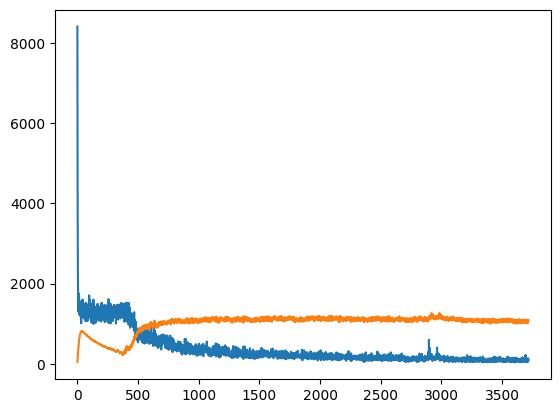

8418.64453125 104.94075012207031
lr 3e-4, 0.1lpips: 9192.9423828125 4540.0302734375
lr 1e-4, 0.1lpips: 8918.8046875 1402.575927734375
lr 3e-5, 0.1lpips: 9193.6279296875 1534.5819091796875
lr 1e-4, 0.2lpips: 9000.794921875 1412.0052490234375


In [49]:
import glob
import json
from pathlib import Path
import matplotlib.pyplot as plt

# raw_losses = raw_loss_log
SAVE_DIR = Path('vae-wallcast4')
latest_checkpoint_number = max([
  int(Path(path).name[len('check'):][:-len('.pt')]) for path in glob.glob('*.pt', root_dir=SAVE_DIR)
], default=-1)
raw_losses = []
for checkpoint_number in range(latest_checkpoint_number + 1):
  with open(SAVE_DIR / f'stats{checkpoint_number}.json', 'r') as f:
    train_stats = json.load(f)
  raw_losses.extend(train_stats['raw_loss_log'])

plt.plot([v[0] for v in raw_losses])
plt.plot([v[1] for v in raw_losses])
plt.show()
print(raw_losses[0][0], raw_losses[-1][0])
print('lr 3e-4, 0.1lpips: 9192.9423828125 4540.0302734375')
print('lr 1e-4, 0.1lpips: 8918.8046875 1402.575927734375')
print('lr 3e-5, 0.1lpips: 9193.6279296875 1534.5819091796875')
print('lr 1e-4, 0.2lpips: 9000.794921875 1412.0052490234375')

Encoding took 0.011183800001163036s.


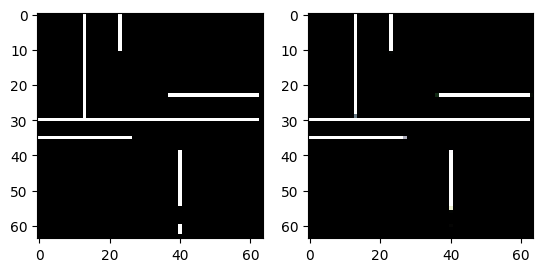

In [58]:
import time
import numpy as np
import matplotlib.pyplot as plt

# original_image = trainset[4][0].unsqueeze(0)
# load_vae = vae
device = 'cuda'
load_vae = make_vae().to('cuda')
load_vae.load_state_dict(torch.load('vae-wallcast4/check57.pt'))
testset = nav2d_dataset(1)
testset.transform = transforms.Compose([
  transforms.Normalize((0.5,), (0.5,)),
  # transforms.GaussianBlur(5, 1.0),
  # transforms.GaussianBlur(5, 1.0),
])
original_image = testset[0].unsqueeze(0).to(device)
start_time = time.perf_counter()
load_vae.encode(original_image)
encoding_time = time.perf_counter() - start_time
print(f'Encoding took {encoding_time}s.')
with torch.no_grad():
  reconstructed_image = load_vae.forward_recons(original_image).cpu().numpy().squeeze(0).transpose(1, 2, 0)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(denormalize(original_image).cpu().numpy().squeeze(0).transpose(1, 2, 0))
axes[1].imshow(denormalize(reconstructed_image))